In [3]:
%matplotlib inline
import glob
import os
import librosa
import librosa.display
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf

from matplotlib.pyplot import specgram





In [6]:
def load_sound_files(file_paths):
    raw_sounds = []
    for fp in file_paths:
        fp ='data/fold1/'+ fp
        X,sr = librosa.load(fp)
        raw_sounds.append(X)
    return raw_sounds

def plot_waves(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 100)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        librosa.display.waveplot(np.array(f),sr=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle("Figure 1: Waveplot",x=0.5, y=0.915,fontsize=18)
    plt.show()
    
def plot_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 100)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        specgram(np.array(f), Fs=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle("Figure 2: Spectrogram",x=0.5, y=0.915,fontsize=18)
    plt.show()

def plot_log_power_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 100)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        D = librosa.logamplitude(np.abs(librosa.stft(f))**2, ref_power=np.max)
        librosa.display.specshow(D,x_axis='time' ,y_axis='log')
        plt.title(n.title())
        i += 1
    plt.suptitle("Figure 3: Log power spectrogram",x=0.5, y=0.915,fontsize=18)
    plt.show()

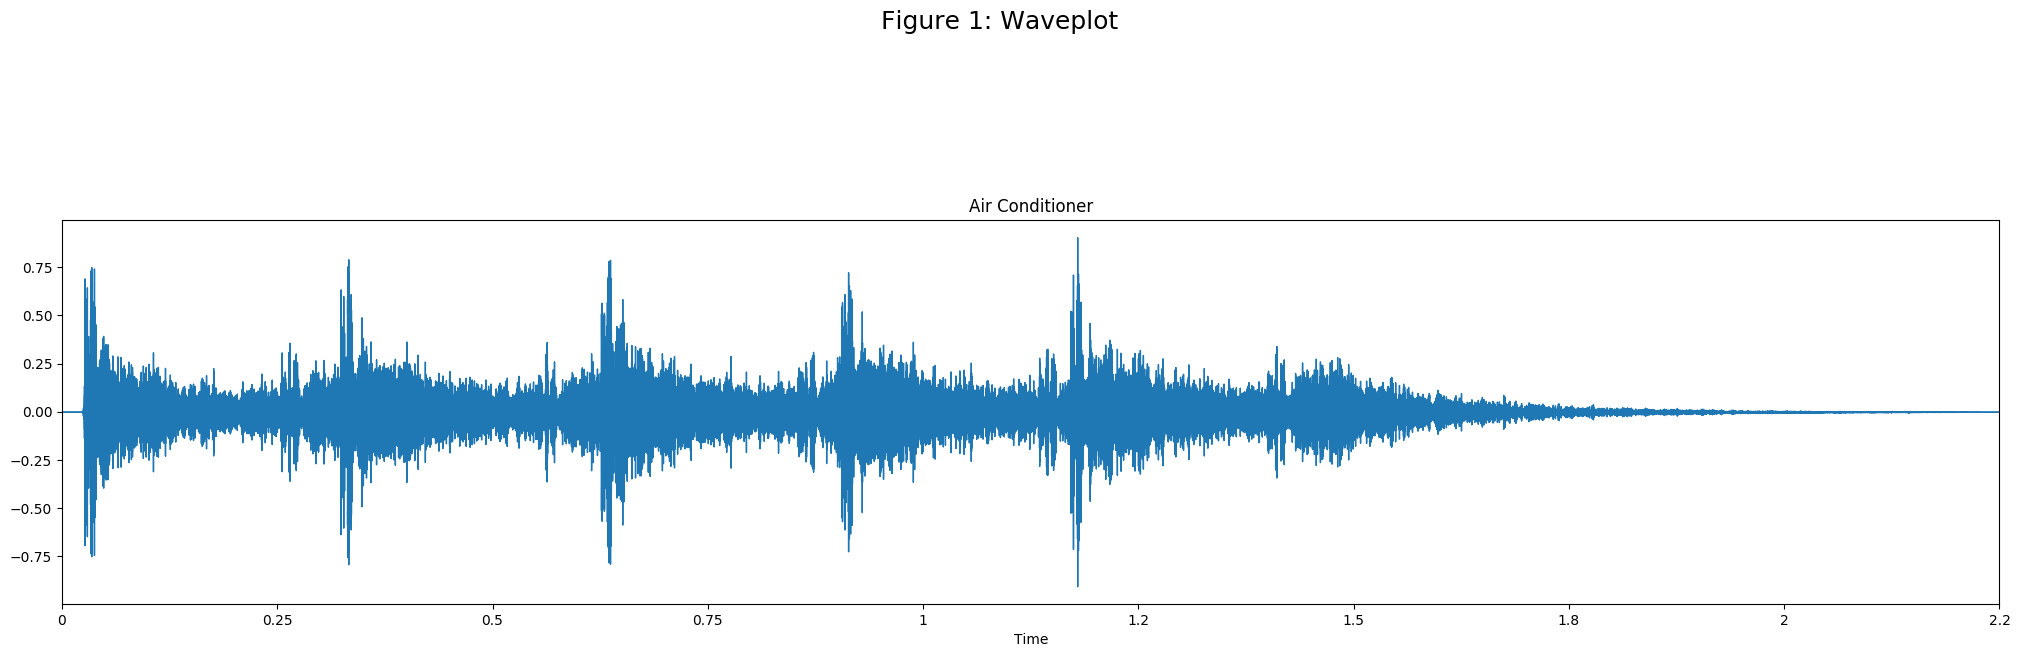

/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7235: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


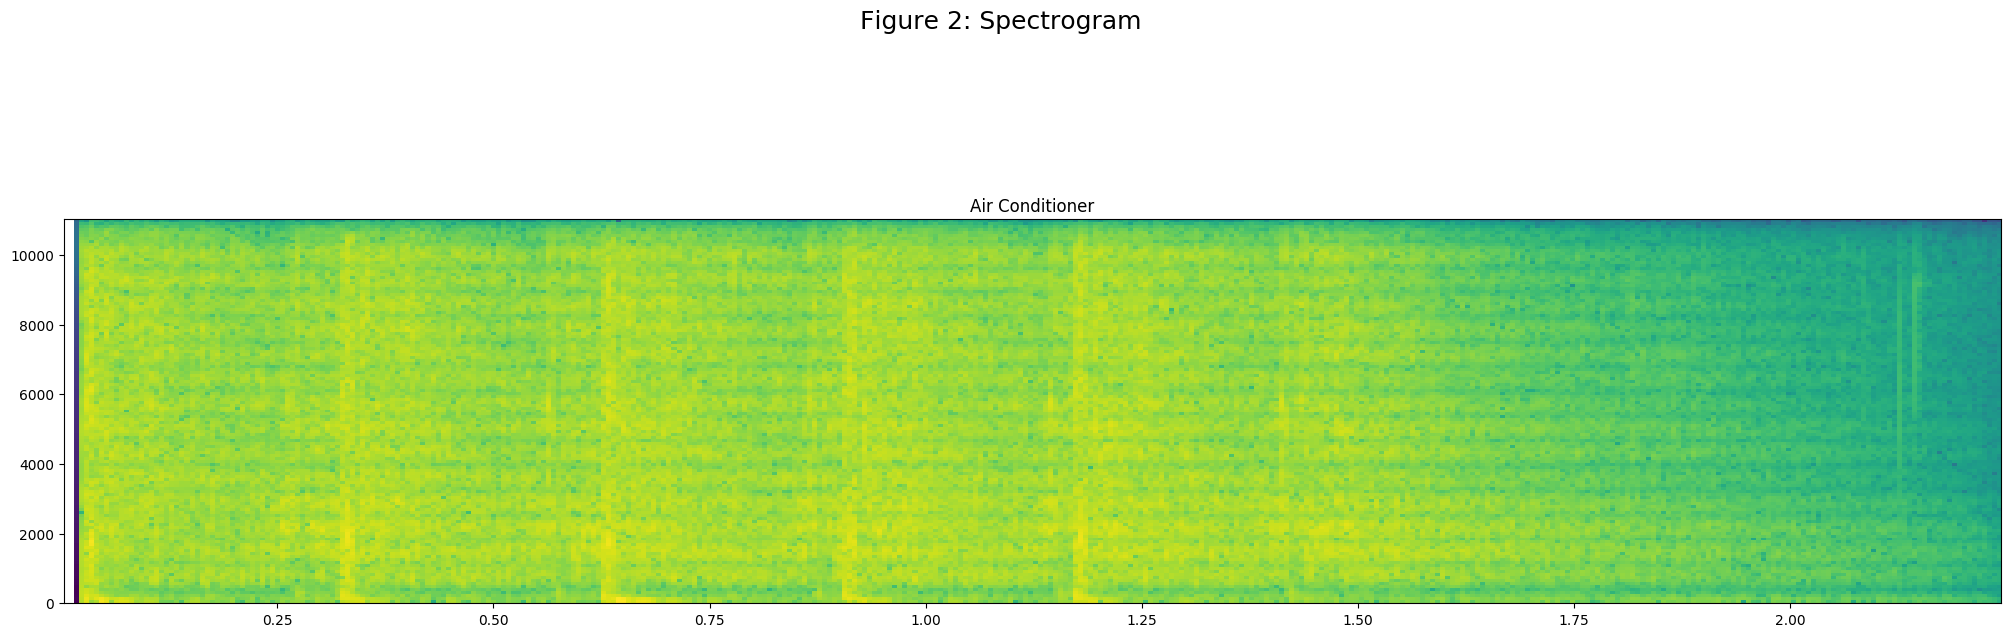

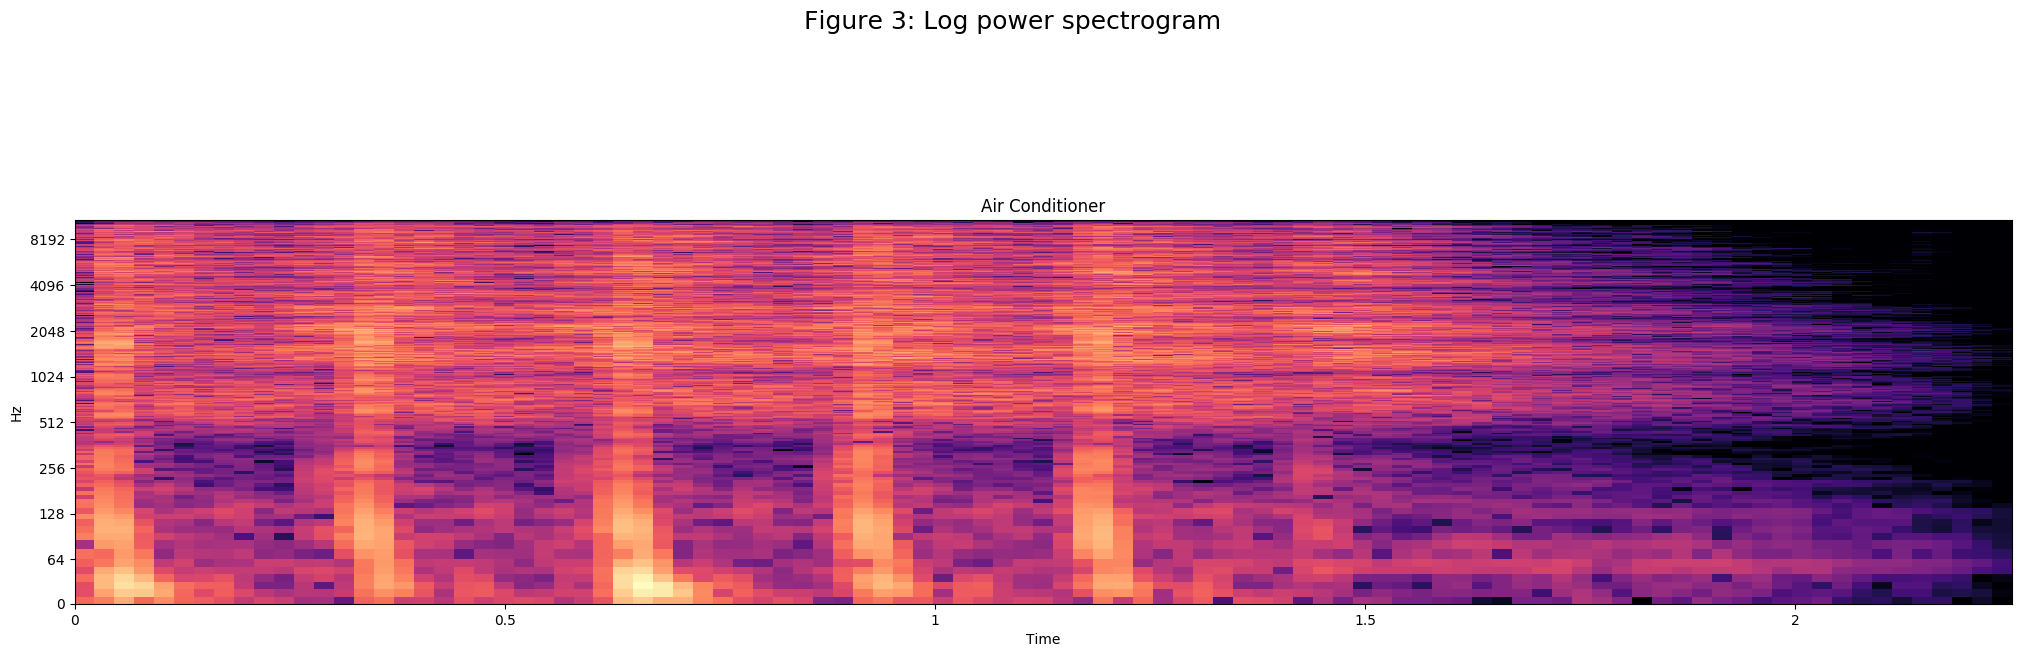

In [7]:
sound_file_paths = ['7061-6-0-0.wav']#["57320-0-0-7.wav"]

# ,"24074-1-0-3.wav","15564-2-0-1.wav","31323-3-0-1.wav",
# "46669-4-0-35.wav","89948-5-0-0.wav","40722-8-0-4.wav",
# "103074-7-3-2.wav","106905-8-0-0.wav","108041-9-0-4.wav"]

sound_names = ["air conditioner","car horn","children playing",
"dog bark","drilling","engine idling", "gun shot",
"jackhammer","siren","street music"]

raw_sounds = load_sound_files(sound_file_paths)

plot_waves(sound_names,raw_sounds)
plot_specgram(sound_names,raw_sounds)
plot_log_power_specgram(sound_names,raw_sounds)

In [46]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
    new_mfccs = mfccs.reshape(40,1)
    new_mel = contrast.reshape(1,contrast.shape[0])
    new = new_mfccs.dot(new_mel)
        
    return mfccs,chroma,mel,contrast,tonnetz

def parse_audio_files(parent_dir,sub_dirs,file_ext="*.wav"):
    features, labels = np.empty((0,193)), np.empty(0)
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            try:
              mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn)
            except Exception as e:
              print( "Error encountered while parsing file: ", fn)
              continue
            ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
            features = np.vstack([features,ext_features])
            labels = np.append(labels, fn.split('/')[2].split('-')[1])
    return np.array(features), np.array(labels, dtype = np.int)

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [48]:
parent_dir = 'data'
tr_sub_dirs = ["fold3"]
# ts_sub_dirs = ["fold1"]
tr_features, tr_labels = parse_audio_files(parent_dir,tr_sub_dirs)
# ts_features, ts_labels = parse_audio_files(parent_dir,ts_sub_dirs)

tr_labels = one_hot_encode(tr_labels)
# ts_labels = one_hot_encode(ts_labels)

IndexError: index 8 is out of bounds for axis 1 with size 8

In [22]:
tr_features.shape
np.save('tr_features.npy', tr_features, allow_pickle=True)
np.save('tr_labels.npy', tr_labels, allow_pickle=True)
tr_features = np.load('tr_features.npy')
tr_labels = np.load('tr_labels.npy')

In [166]:
# Create your first MLP in Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation
from keras.layers.normalization import BatchNormalization
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)

In [179]:
# create model
model = Sequential()

model.add(Dense(12, input_dim=193, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(10, activation='softmax'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
model.fit(tr_features, tr_labels, epochs=120, batch_size=10)
# evaluate the model
# scores = model.evaluate(ts_features, ts_labels)
# print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
# print(scores)
# predictions = model.predict(tr_features)
# print(np.argmax(predictions, axis=1))
# print(np.argmax(tr_labels, axis=1))

Epoch 1/120
1761/1761 [==============================] - 3s - loss: 0.3432 - acc: 0.8957     
Epoch 2/120
1761/1761 [==============================] - 0s - loss: 0.3046 - acc: 0.8989     
Epoch 3/120
1761/1761 [==============================] - 0s - loss: 0.2809 - acc: 0.9011     
Epoch 4/120
1761/1761 [==============================] - 0s - loss: 0.2667 - acc: 0.9044     
Epoch 5/120
1761/1761 [==============================] - 0s - loss: 0.2523 - acc: 0.9081     
Epoch 6/120
1761/1761 [==============================] - 0s - loss: 0.2404 - acc: 0.9115     
Epoch 7/120
1761/1761 [==============================] - 0s - loss: 0.2301 - acc: 0.9157     
Epoch 8/120
1761/1761 [==============================] - 0s - loss: 0.2221 - acc: 0.9179     
Epoch 9/120
1761/1761 [==============================] - 0s - loss: 0.2212 - acc: 0.9162     
Epoch 10/120
1761/1761 [==============================] - 0s - loss: 0.2145 - acc: 0.9195     
Epoch 11/120
1761/1761 [==============================] - 0

In [182]:
parent_dir = 'data'
tf_sub_dirs = ["my_data"]

tf_features, tf_labels = parse_audio_files(parent_dir,tf_sub_dirs)
print(tf_labels)
# ts_features, ts_labels = parse_audio_files(parent_dir,ts_sub_dirs)
tf_labels = np.array([[1,0,0,0,0,0,0,0,0,0],[0,0,0,1,0,0,0,0,0,0],[0,1,0,0,0,0,0,0,0,0],[1,0,0,0,0,0,0,0,0,0],[0,0,0,1,0,0,0,0,0,0],[0,0,0,1,0,0,0,0,0,0]])
# tf_labels = one_hot_encode(tf_labels)
# ts_labels = one_hot_encode(ts_labels)

[0 3 1 0 3 3]


In [183]:

# scores = model.evaluate(tf_features, np.array(tf_labels))
# # print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
# # print(scores)
predictions = model.predict(tf_features)
print(np.argmax(predictions,axis=1))
# # print(np.argmax(tr_labels, axis=1))

[0 8 3 8 3 3]


In [79]:
training_epochs = 100
n_dim = tr_features.shape[1]
n_classes = 10
n_hidden_units_one = 280 
n_hidden_units_two = 300
sd = 1 / np.sqrt(n_dim)
learning_rate = 0.01

In [18]:
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.tanh(tf.matmul(X,W_1) + b_1)

W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], 
mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.sigmoid(tf.matmul(h_1,W_2) + b_2)

W = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)

init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [17]:
from sklearn.metrics import precision_recall_fscore_support

cost_function = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)
print(y_)
correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:tr_features,Y:tr_labels})
        cost_history = np.append(cost_history,cost)
    
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: ts_features})
    y_true = sess.run(tf.argmax(ts_labels,1))
    print("Test accuracy: ",round(sess.run(accuracy, 
    	feed_dict={X: tr_features,Y: tr_labels}),3))
print(ts_features.shape)
# fig = plt.figure(figsize=(10,8))
# plt.plot(cost_history)
# plt.axis([0,training_epochs,0,np.max(cost_history)])
# plt.show()

p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average="micro")
print(y_true, y_pred)
print( "F-Score:", round(f,3))

NameError: name 'Y' is not defined

In [4]:
parent_dir = 'data'
tr_sub_dirs = ["fold1","fold2"]
ts_sub_dirs = ["fold3"]
tr_features, tr_labels = parse_audio_files(parent_dir,tr_sub_dirs)
ts_features, ts_labels = parse_audio_files(parent_dir,ts_sub_dirs)

tr_labels = one_hot_encode(tr_labels)
ts_labels = one_hot_encode(ts_labels)

/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


KeyboardInterrupt: 